# **Setup and Scaled Data Selection**

In [3]:
# Part 1: Setup and Neural Network Scaling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import time

# 1. Load the Guayas data
df = pd.read_csv('guayas_prepared.csv')
df['date'] = pd.to_datetime(df['date'])

# 2. Filter for Target Horizon (Jan - Mar 2014)
mask = (df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')
df_target = df.loc[mask].copy()

# 3. Scale the target (unit_sales)
# Neural networks perform significantly better with data between 0 and 1
scaler = MinMaxScaler()
df_target['unit_sales_scaled'] = scaler.fit_transform(df_target[['unit_sales']])

print("Data scaled and ready for sequencing.")

Data scaled and ready for sequencing.


# **2.Creating Sequences**

LSTMs require data  To predict today's sales, the model looks at the last 7 days.

In [4]:
# Part 2: Sequencing the Data
def create_sequences(data, window_size=7):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# We use the scaled sales for the sequence
window = 7
sales_data = df_target['unit_sales_scaled'].values
X, y = create_sequences(sales_data, window)

# Reshape for LSTM: [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Chronological Split (Jan-Feb Train, March Test)
# Approximate split at 60 days
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Sequences created. Training shape: {X_train.shape}")

Sequences created. Training shape: (3315, 7, 1)


# **3.LSTM Architecture and Training**
We build a simple but effective network with an EarlyStopping monitor to save time and prevent overfitting.

In [5]:
# Part 3: Model Architecture and Training
model = Sequential([
    Input(shape=(window, 1)),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

#  Use EarlyStopping to stop when the model stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)
lstm_train_time = time.time() - start_time
print(f"LSTM Training Complete in {lstm_train_time:.2f} seconds.")

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - va

 **# 4: Evaluation and Comparison**

We must "un-scale" the predictions back into real unit sales to calculate our metrics.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
--- LSTM Performance (Guayas) ---
MAE: 5.31
RMSE: 9.49
Bias: 0.48


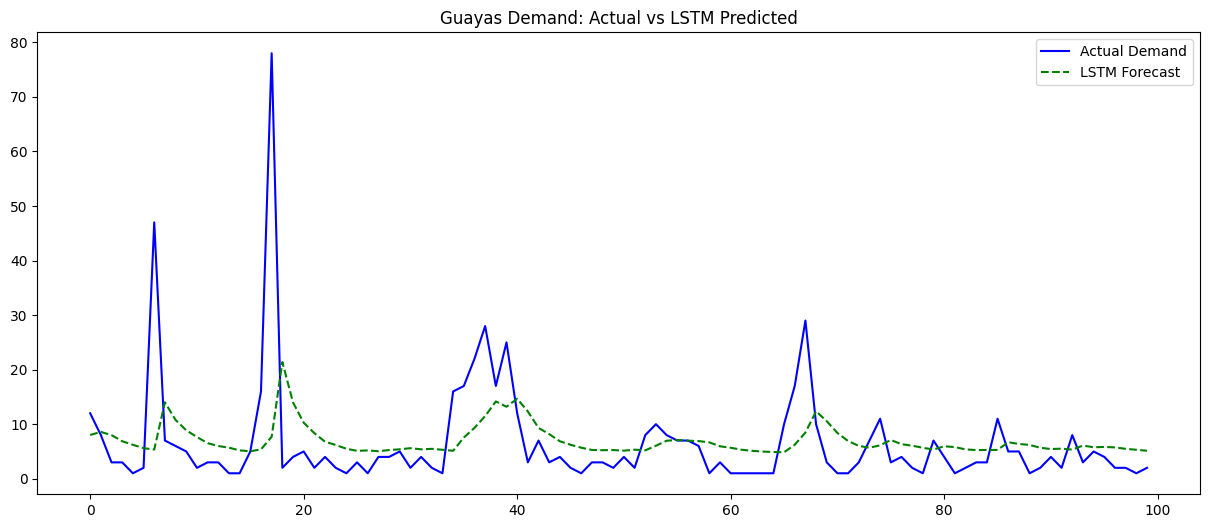

In [6]:
# Part 4: Final LSTM Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Predict and Inverse Scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 2. Calculate Metrics
mae_lstm = mean_absolute_error(y_test_unscaled, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
bias_lstm = np.mean(y_pred - y_test_unscaled)

print(f"--- LSTM Performance (Guayas) ---")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"Bias: {bias_lstm:.2f}")

# 3. Visualize Results
plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled[:100], label='Actual Demand', color='blue')
plt.plot(y_pred[:100], label='LSTM Forecast', color='green', linestyle='--')
plt.title('Guayas Demand: Actual vs LSTM Predicted')
plt.legend()
plt.show()